# SageMaker Inference Recommender for a NLP transformer model

## Contents
[1. Introduction](#1.-Introduction)  
[2. Download HuggingFace Pretrained Model](#2.-Download-HuggingFace-Pretrained-Model)  
[3. Deploy HuggingFace model](#3.-Deploy-HuggingFace-model)  
[4. Register Model Version/Package](#4.-Register-Model-Version/Package)  
[5. Create a SageMaker Inference Recommender Default Job](#5:-Create-a-SageMaker-Inference-Recommender-Default-Job)   
[6. Instance Recommendation Results](#6.-Instance-Recommendation-Results)   
[7. Create a SageMaker Inference Recommender Advanced Job](#7.-Custom-Load-Test)  
[8. Describe result of an Advanced Job](#8.-Custom-Load-Test-Results)  

## 1. Introduction

Deploying and scaling NLP models in a production set up can be a hard engineering problem
1. NLP models are very large in size, often contain millions of model parameters
2. Requires accelerated compute infrastructure(GPUs) to speed up huge and complex calculations during inference
3. Scaling requirements to satisfy concurreny,latency and throughput of ML applications
4. Finding best instance type and configurations can be expensive and time consuming

SageMaker Inference Recommender is a new capability of SageMaker that reduces the time required to get machine learning (ML) models in production by automating performance benchmarking and load testing models across SageMaker ML instances. You can use Inference Recommender to deploy your model to a real-time inference endpoint that delivers the best performance at the lowest cost.Inference Recommender helps you select the best instance type and configuration (such as instance count, container parameters, and model optimizations) for your ML models and workloads.


#### Installs and Set Up
To begin, let's update the required packages i.e. SageMaker Python SDK, `boto3`, `botocore` and `awscli`

In [ ]:
import sys

!{sys.executable} -m pip3 install botocore boto3 awscli ipywidgets seaborn --upgrade -q
!pip3 install sagemaker --upgrade
!pip3 install torch -q
!pip3 install transformers

#### **Note: Restart the notebook after installing the above packages.**

In [3]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

In [4]:
restartkernel()

#### Imports

In [7]:
#generic packages
import sys
from time import gmtime, strftime
import datetime
import boto3
import pprint
import pandas as pd
import time

#sagemaker
import sagemaker
from sagemaker.s3 import S3Uploader,s3_path_join
from sagemaker.huggingface import HuggingFaceModel
from sagemaker import get_execution_role
import sagemaker
from sagemaker.s3 import S3Uploader,s3_path_join

#visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#hugging face transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

#### Variables

In [9]:
#sagemaker
sess = sagemaker.Session()
role = 'arn:aws:iam::156991241640:role/service-role/AmazonSageMaker-ExecutionRole-20210302T095973' #sagemaker.get_execution_role()
sagemaker_session_bucket = sess.default_bucket()
prefix = "inference-receommender"
client = boto3.client("sagemaker")

current_timestamp = strftime('%m-%d-%H-%M', gmtime())
endpoint_name=f"nlp-benchmark-bert-base-uncased-{current_timestamp}"
MODEL = "bert-base-uncased"

## 2. Download HuggingFace Pretrained Model



In this notebook, we will download pre-trained `bert-base-uncased` model from HuggingFace package and use it for Sequence classification task. We will use `AutoModelForSequenceClassification`, a generic sequence classification model class to load pre-trained model weights and `AutoTokenizer`, a generic tokenizer classes to instantiate a tokenizer from a pre-trained model vocabulary. Once you instantiate model and tokenizer, we will save them to `model_artifacts` directory locally.

In [ ]:
!mkdir model_artifacts

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model.save_pretrained('model_artifacts')
tokenizer.save_pretrained('model_artifacts')

('model_artifacts/vocab.txt',
 'model_artifacts/special_tokens_map.json',
 'model_artifacts/added_tokens.json')

#### Package the saved model to tar.gz format

Once the model is downloaded, we need to package (tokenizer and model weights) it to `.tar.gz` format as expected by Amazon SageMaker. 

In [12]:
!cd model_artifacts && tar zcvf bert_model.tar.gz * 
!mv model_artifacts/bert_model.tar.gz ./bert_model.tar.gz

a config.json
a pytorch_model.bin
a special_tokens_map.json
a tokenizer_config.json
a vocab.txt


#### Upload Pre-trained Model to S3

We are going to use the `sagemaker.s3.S3Uploader` api to upload our model to an S3 location. We will provide this s3 path to the `HuggingFaceModel` class during deployment.

In [14]:
# uploads a given file to S3.
upload_path = s3_path_join("s3://",sagemaker_session_bucket,prefix)
print(f"Uploading Model to {upload_path}")
model_uri = S3Uploader.upload('bert_model.tar.gz',upload_path)
print(f"Uploaded model to {model_uri}")

Uploading Model to s3://sagemaker-us-east-2-156991241640/inference-receommender
Uploaded model to s3://sagemaker-us-east-2-156991241640/inference-receommender/bert_model.tar.gz


## 3. Deploy HuggingFace model

We will deploy our pre-trained model which we packaged and uploaded to s3 in the previous steps, using the model_data argument to specify the s3 location of your tokenizer and model weights.

#### Parameters for `HuggingFaceModel` class
We will use following parameters in this lab for deploying the model. 
* `model_data (str)` – The Amazon S3 location of a SageMaker model data .tar.gz file.

* `role (str)` – An AWS IAM role specified with either the name or full ARN. The Amazon SageMaker training jobs and APIs that create Amazon SageMaker endpoints use this role to access training data and model artifacts. After the endpoint is created, the inference code might use the IAM role, if it needs to access an AWS resource.

* `transformers_version (str)` – Transformers version you want to use for executing your model training code. Defaults to None. Required unless image_uri is provided.

* `pytorch_version (str)` – PyTorch version you want to use for executing your inference code. Defaults to None. Required unless tensorflow_version is provided. List of supported versions: https://github.com/aws/sagemaker-python-sdk#huggingface-sagemaker-estimators.

* `py_version (str)` – Python version you want to use for executing your model training code. Defaults to None. Required unless image_uri is provided.

For details about other paramets, please click [here](#https://sagemaker.readthedocs.io/en/stable/frameworks/huggingface/sagemaker.huggingface.html?highlight=huggingfacemodel#sagemaker.huggingface.model.HuggingFaceModel).

In [15]:
# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=model_uri,  # path to your trained sagemaker model
   role=role, # iam role with permissions to create an Endpoint
   transformers_version="4.6", # transformers version used
   pytorch_version="1.7", # pytorch version used
   py_version="py36", # python version of the DLC
)

We created a HuggingFace model class in the above step. Now, we will deploy the model to a SageMaker real time endpoint. We are deploying the model to a GPU accelerated instance type. 
Note: For the inference recommender we will retrieve the image_uri based on this endpoint, if you wish to run inference recommender on CPU based instance, change deploy step with CPU based instance type and run inference recommender. 

In [16]:
# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
   initial_instance_count=1,
   instance_type="ml.g4dn.xlarge",
   endpoint_name=endpoint_name
)

------!

### Sample Inference

We use below sample inference payload, pass it to the predictor to get inference results. 

In [17]:
data = {
   "inputs": "This is really exciting! The new Hugging Face SageMaker DLC makes it super easy to deploy large NLP models in production."
}

# request
predictor.predict(data)

[{'label': 'LABEL_0', 'score': 0.548836350440979}]

### Tar the payload and upload to S3
We need to create an archive that contains individual files that Inference Recommender can send to your SageMaker Endpoints. Inference Recommender will randomly sample files from this archive so make sure it contains a similar distribution of payloads you'd expect in production. Note that your inference code must be able to read in the file formats from the sample payload.

We now have a model archive ready. We need to upload it to S3 before we can use it with Inference Recommender, so we will use the SageMaker Python SDK to handle the upload.

In [22]:
import json
with open('payload.json', 'w') as fp:
    json.dump(data, fp)

In [23]:
!tar -cvzf payload.tar.gz payload.json
!aws s3 cp payload.tar.gz s3://{sagemaker_session_bucket}/{prefix}/
    
sample_payload_url= f"s3://{sagemaker_session_bucket}/{prefix}/payload.tar.gz"
sample_payload_url

a payload.json
upload: ./payload.tar.gz to s3://sagemaker-us-east-2-156991241640/inference-receommender/payload.tar.gz


's3://sagemaker-us-east-2-156991241640/inference-receommender/payload.tar.gz'

### Container Images and Model URL

Now that we deployed the model, we will retrieve model artifacts and Inference container image and use it in SageMaker inference recommender.

In [24]:
%%time

ended = False
while not ended:
    endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
    if endpoint_response["EndpointStatus"] in ["InService", "Failed"]:
        ended = True
    else:
        print("Endpoint Creation in progress")
        time.sleep(300)

if endpoint_response["EndpointStatus"] == "Failed":
    print("Endpoint creation failed ")
    print("Failed Reason: {}".endpoint_response["FailureReason"])
else:
    endpoint_config_name = endpoint_response["EndpointConfigName"]
    image_uri = endpoint_response["ProductionVariants"][0]["DeployedImages"][0]["SpecifiedImage"]
    endpoint_config_response = client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    model_name = endpoint_config_response["ProductionVariants"][0]["ModelName"]
    endpoint_model_response = client.describe_model(ModelName=model_name)
    model_url = endpoint_model_response["PrimaryContainer"]["ModelDataUrl"]
    print(image_uri)
    print(model_url)
    print("Endpoint creation completed")

763104351884.dkr.ecr.us-east-2.amazonaws.com/huggingface-pytorch-inference:1.7-transformers4.6-gpu-py36-cu110-ubuntu18.04
s3://sagemaker-us-east-2-156991241640/inference-receommender/bert_model.tar.gz
Endpoint creation completed
CPU times: user 31.7 ms, sys: 10.3 ms, total: 42 ms
Wall time: 587 ms


## 4. Register Model Version/Package

Inference Recommender expects the model to be packaged in the model registry. Here, we are creating a model package group and a model package version. The model package version which takes container, model `URL` etc. will now allow you to pass additional information about the model like `Domain`, `Task`, `Framework`, `FrameworkVersion`, `NearestModelName`, `SamplePayloadUrl`
You specify a list of the instance types that are used to generate inferences in real-time in`SupportedRealtimeInferenceInstanceTypes` parameter.

For Inference on NLP data, e.g. HuggingFace Models you want to use accelerated GPU based computing instances. Here, we have used ml.p2, ml.p3, ml.g4dn type instances in `SupportedRealtimeInferenceInstanceTypes` parameter



As `SamplePayloadUrl` and `SupportedContentTypes` parameters are essential for benchmarking the endpoint, we also highly recommend that you specify `Domain`, `Task`, `Framework`, `FrameworkVersion`, `NearestModelName` for better inference recommendation.


In [25]:
ml_domain = "NATURAL_LANGUAGE_PROCESSING"    
ml_task = "FILL_MASK"
framework = "PYTORCH"
framework_version = "1.7"

#sagemaker model registry
model_package_group_name = f"nlp-bert-mg-{current_timestamp}"
model_package_group_description = "model benchmark use case"
nearest_model_name = "bert-base-uncased"                          #The name of the ML model as standardized by common model zoos
input_content_type="application/json"                             #MIME types for input
response_content_type="application/json"                          #MIME types for input
model_package_description = "model bert-base-uncased benchmark"
default_job = f"nlp-basic-inference-recommender-job-{current_timestamp}"
advanced_job = f"nlp-advanced-inference-recommender-job-{current_timestamp}"

In [26]:
model_package_group_input_dict = {
 "ModelPackageGroupName" : model_package_group_name,
 "ModelPackageGroupDescription" : model_package_group_description,
}

model_package_group_response = client.create_model_package_group(**model_package_group_input_dict)

In [27]:
model_package_input_dict = {
        "ModelPackageGroupName" :model_package_group_name,
        "Domain": ml_domain,
        "Task": ml_task,
        "SamplePayloadUrl": sample_payload_url,
        "ModelPackageDescription" : model_package_group_description,
            "InferenceSpecification": {
                    "Containers": [
                        {
                            "Image": image_uri,
                            "ModelDataUrl": model_url,
                            "Framework": framework.upper(), 
                            "FrameworkVersion": framework_version,
                            "NearestModelName": nearest_model_name
                        }
                        ],
                    "SupportedContentTypes": [input_content_type],
                    "SupportedResponseMIMETypes": [response_content_type],
                    "SupportedRealtimeInferenceInstanceTypes": ['ml.p3.8xlarge','ml.p3.2xlarge','ml.p3.16xlarge','ml.p2.16xlarge',
                                                                'ml.g4dn.xlarge','ml.g4dn.8xlarge','ml.g4dn.4xlarge','ml.g4dn.2xlarge',
                                                                'ml.g4dn.16xlarge','ml.g4dn.12xlarge']
            }
        }

model_package_response = client.create_model_package(**model_package_input_dict)
model_package_arn = model_package_response["ModelPackageArn"]
print('ModelPackage Version ARN : {}'.format(model_package_arn))

ModelPackage Version ARN : arn:aws:sagemaker:us-east-2:156991241640:model-package/nlp-bert-mg-01-04-16-33/1


## 5: Create a SageMaker Inference Recommender Default Job

Now with your model in Model Registry, you can kick off a 'Default' job to get instance recommendations. This only requires your `ModelPackageVersionArn` and comes back with recommendations within an hour. 

The output is a list of instance type recommendations with associated environment variables, cost, throughput and latency metrics.

In [28]:
default_response = client.create_inference_recommendations_job(
    JobName=str(default_job),
    JobDescription="NLP Inference Basic Recommender Job",
    JobType="Default",
    RoleArn=role,
    InputConfig={"ModelPackageVersionArn": model_package_response["ModelPackageArn"]},
)

print(default_response)

{'JobArn': 'arn:aws:sagemaker:us-east-2:156991241640:inference-recommendations-job/nlp-basic-inference-recommender-job-01-04-16-33', 'ResponseMetadata': {'RequestId': '07f4fd6d-4a69-4035-93d8-0ac5fcde675c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '07f4fd6d-4a69-4035-93d8-0ac5fcde675c', 'content-type': 'application/x-amz-json-1.1', 'content-length': '131', 'date': 'Tue, 04 Jan 2022 17:11:30 GMT'}, 'RetryAttempts': 0}}


### 6. Instance Recommendation Results

The inference recommender job provides multiple endpoint recommendations in its result. The recommendation includes `InstanceType`, `InitialInstanceCount`, `EnvironmentParameters` which includes tuned parameters for better performance. We also include the benchmarking results like `MaxInvocations`, `ModelLatency`, `CostPerHour` and `CostPerInference` for deeper analysis. The information provided will help you narrow down to a specific endpoint configuration that suits your use case.

Example:   

If your motivation is overall price-performance, then you should focus on `CostPerInference` metrics  
If your motivation is latency/throughput, then you should focus on `ModelLatency` / `MaxInvocations` metrics

Running the Inference recommender job will take ~35 minutes.

In [29]:
%%time

ended = False
while not ended:
    inference_recommender_job = client.describe_inference_recommendations_job(
        JobName=str(default_job)
    )
    if inference_recommender_job["Status"] in ["COMPLETED", "STOPPED", "FAILED"]:
        ended = True
    else:
        print("Inference recommender job in progress")
        time.sleep(300)

if inference_recommender_job["Status"] == "FAILED":
    print("Inference recommender job failed ")
    print("Failed Reason: {}".format(inference_recommender_job["FailedReason"]))
else:
    print("Inference recommender job completed")

Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job completed
CPU times: user 298 ms, sys: 60.6 ms, total: 358 ms
Wall time: 30min 5s


### Detailing out the result

In [30]:
data = [
    {**x["EndpointConfiguration"], **x["ModelConfiguration"], **x["Metrics"]}
    for x in inference_recommender_job["InferenceRecommendations"]
]
df = pd.DataFrame(data)
df.drop("VariantName", inplace=True, axis=1)
pd.set_option("max_colwidth", 400)

By `MaxInvocations` - The maximum number of requests per minute expected for the endpoint.

In [31]:
df.sort_values(by=["MaxInvocations"], ascending=False)

,EndpointName,InstanceType,InitialInstanceCount,EnvironmentParameters,CostPerHour,CostPerInference,MaxInvocations,ModelLatency
2,sm-epc-d95508cc-794c-482c-bc1a-03078559c8b3,ml.p2.16xlarge,1,[],16.559999,0.000008,33403,25
0,sm-epc-9c4282ab-8928-4740-94e1-dff3c32ea1ce,ml.g4dn.xlarge,1,[],0.736000,0.000003,4822,75
1,sm-epc-6a316092-2388-474c-9f73-d20efa2c659c,ml.p3.2xlarge,1,[],3.825000,0.000021,3026,129


By `ModelLatencyThresholds` - The interval of time taken by a model to respond as viewed from SageMaker. The interval includes the local communication time taken to send the request and to fetch the response from the container of a model and the time taken to complete the inference in the container.

In [32]:
df.sort_values(by=["ModelLatency"])

,EndpointName,InstanceType,InitialInstanceCount,EnvironmentParameters,CostPerHour,CostPerInference,MaxInvocations,ModelLatency
2,sm-epc-d95508cc-794c-482c-bc1a-03078559c8b3,ml.p2.16xlarge,1,[],16.559999,0.000008,33403,25
0,sm-epc-9c4282ab-8928-4740-94e1-dff3c32ea1ce,ml.g4dn.xlarge,1,[],0.736000,0.000003,4822,75
1,sm-epc-6a316092-2388-474c-9f73-d20efa2c659c,ml.p3.2xlarge,1,[],3.825000,0.000021,3026,129


#### Visualization

Let's plot the results to visualize the trade-off in terms cost of inference and maximum invocations for different GPU based instance types

<AxesSubplot:xlabel='InstanceType', ylabel='CostPerHour'>

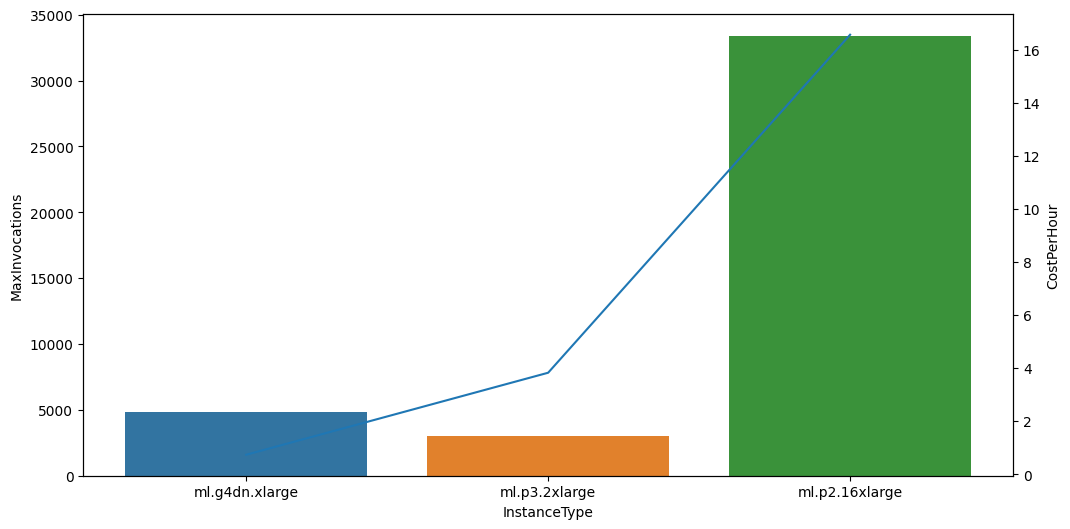

In [33]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()

sns.barplot(data = df, x='InstanceType', y='MaxInvocations', ax=ax1)
sns.lineplot( x='InstanceType', y='CostPerHour',data= df, ax=ax2)

## 7. Custom Load Test

With an 'Advanced' job, you can provide your production requirements, select instance types, tune environment variables and perform more extensive load tests. This typically takes 2 hours depending on your traffic pattern and number of instance types. 

The output is a list of endpoint configuration recommendations (instance type, instance count, environment variables) with associated cost, throughput and latency metrics.

In the below example, we aim to limit the latency requirement to 50 ms. The goal is to find the best performance in the sense of the maximum number of requests per minute expected for the endpoint for a `ml.m5.2xlarge` instance.
We specify `DurationInSeconds`, how long traffic phase should be, to be 120, and the maximum duration of the job, in seconds `JobDurationInSeconds` to 7200.

In [22]:
advanced_response = client.create_inference_recommendations_job(
    JobName=advanced_job,
    JobDescription="NLP bert Inference Advanced Recommender Job",
    JobType="Advanced",
    RoleArn=role,
    InputConfig={
        "ModelPackageVersionArn": model_package_arn,
        "JobDurationInSeconds": 7200,
        "EndpointConfigurations": [{'InstanceType': 'ml.p3.8xlarge'},
                                {'InstanceType': 'ml.p3.2xlarge'},
                                {'InstanceType': 'ml.p3.16xlarge'},
                                {'InstanceType': 'ml.p2.16xlarge'},
                                {'InstanceType': 'ml.g4dn.xlarge'},
                                {'InstanceType': 'ml.g4dn.8xlarge'},
                                {'InstanceType': 'ml.g4dn.4xlarge'},
                                {'InstanceType': 'ml.g4dn.2xlarge'},
                                {'InstanceType': 'ml.g4dn.16xlarge'},
                                {'InstanceType': 'ml.g4dn.12xlarge'}],
        "TrafficPattern": {
            "TrafficType": "PHASES",
            "Phases": [{"InitialNumberOfUsers": 1, "SpawnRate": 3, "DurationInSeconds": 120}],
        },
        "ResourceLimit": {
            "MaxNumberOfTests": 10,
            "MaxParallelOfTests": 2
        },
    },
    StoppingConditions={
        "MaxInvocations": 60,
        "ModelLatencyThresholds": [{"Percentile": "P95", "ValueInMilliseconds": 20}],
    },
)

print(advanced_response)

{'JobArn': 'arn:aws:sagemaker:us-east-1:917092859813:inference-recommendations-job/nlp-advanced-inference-recommender-job-01-03-20-55', 'ResponseMetadata': {'RequestId': '2a75020d-3d62-486d-9301-da30f5299598', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2a75020d-3d62-486d-9301-da30f5299598', 'content-type': 'application/x-amz-json-1.1', 'content-length': '134', 'date': 'Tue, 04 Jan 2022 00:54:10 GMT'}, 'RetryAttempts': 0}}


### 8. Custom Load Test Results

Inference recommender runs benchmarks on both of the endpoint configurations. Below is the result.

Running the Inference recommender job will take ~15 minutes.


In [23]:
%%time

ended = False
while not ended:
    inference_recommender_job = client.describe_inference_recommendations_job(
        JobName=str(advanced_job)
    )
    if inference_recommender_job["Status"] in ["COMPLETED", "STOPPED", "FAILED"]:
        ended = True
    else:
        print("Inference recommender job in progress")
        time.sleep(300)

if inference_recommender_job["Status"] == "FAILED":
    print("Inference recommender job failed ")
    print("Failed Reason: {}".inference_recommender_job["FailedReason"])
else:
    print("Inference recommender job completed")

Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job completed
CPU times: user 302 ms, sys: 57.9 ms, total: 360 ms
Wall time: 1h 15min 4s


### Detailing out the result

Analyzing load test result, we can see that to achieve 50 ms latency, we will need two `ml.m5.2xlarge` instances, with `MaxInvocations` (The maximum number of requests per minute expected for the endpoint) of ~736.

In [24]:
data = [
    {**x["EndpointConfiguration"], **x["ModelConfiguration"], **x["Metrics"]}
    for x in inference_recommender_job["InferenceRecommendations"]
]
df = pd.DataFrame(data)
df.drop("VariantName", inplace=True, axis=1)
pd.set_option("max_colwidth", 400)
df.head()

,EndpointName,InstanceType,InitialInstanceCount,EnvironmentParameters,CostPerHour,CostPerInference,MaxInvocations,ModelLatency
0,sm-epc-3ea0cba0-027e-4d81-9d1e-3f0bee142892,ml.g4dn.12xlarge,1,[],4.890,0.000047,1733,14
1,sm-epc-4fa41173-0e16-45b5-b3fc-246de065b52a,ml.g4dn.8xlarge,1,[],2.720,0.000027,1701,18
2,sm-epc-3b263d89-5a2a-4bc1-94c7-3b6808afd94f,ml.g4dn.4xlarge,1,[],1.505,0.000014,1804,18
3,sm-epc-f712c9fe-200e-46b0-8acc-a06e8b170c58,ml.g4dn.2xlarge,1,[],0.940,0.000010,1631,15
4,sm-epc-a4ea9afb-cc71-442f-a9ff-f4abc16c8d1f,ml.g4dn.xlarge,1,[],0.736,0.000011,1168,20


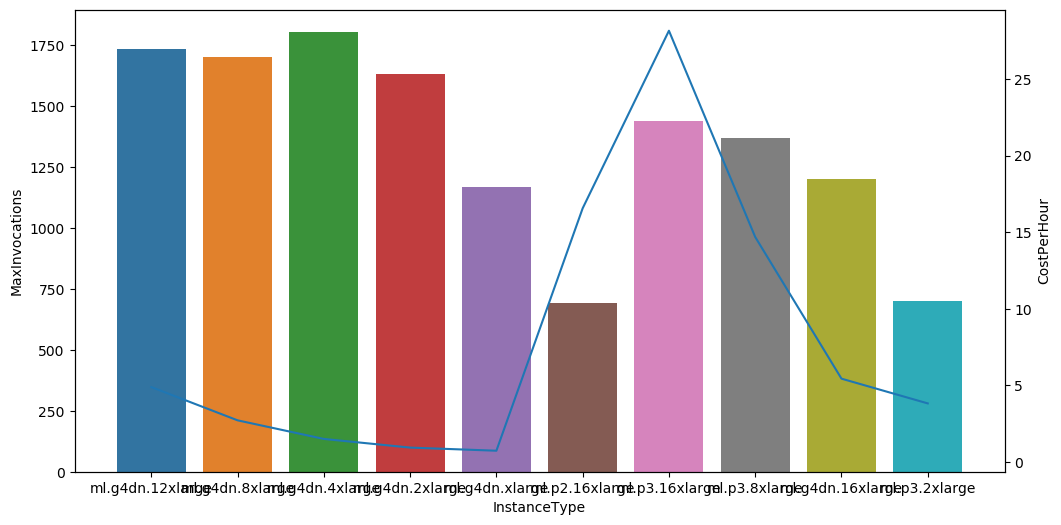

In [25]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

#sns.lineplot(data = df['max_invocations'], marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data = df, x='InstanceType', y='MaxInvocations', ax=ax1)
sns.lineplot( x='InstanceType', y='CostPerHour',data= df, ax=ax2)